# Recursive Feature Elimination of MRI Features
In this notebook MRI based features of Cerebral Blood Flow(CBF), arterial Blood Volume(aBV), Fractional Anisotropy(FA), Mean Diffusivity(MD), functional MRI(fMRI), spectroscopy are used to predict Parkinson's Disease Mild Cognitive Impairment (PD-MCI).
Most informative features are tried to be found as biomarkers indicating PD-MCI status. 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pylab 
import scipy.stats as stats
import time
import sklearn.ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from pandas import ExcelWriter
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.svm import LinearSVC

from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
import collections

import re

import winsound
frequency = 2500  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second

## Reading Excel Files
Files containing each modalities are imported as DataFrames. MR spectroscopic data are imported from four different files including four different metabolite ratio values of Glutamine (Glu), N-acetyl aspartate (Naa), Myo-inositol (Ins) and Choline divided by Creatine.

In [2]:
cd C:\Users\DELL003\Desktop\PD_Documents

C:\Users\DELL003\Desktop\PD_Documents


In [3]:
FA = pd.read_excel('DTI.xlsx', sheet_name = 'FA', index_col='ID')
FA.shape

(77, 20)

In [4]:
MD = pd.read_excel('DTI.xlsx', sheet_name = 'MD', index_col='ID')
MD.shape

(77, 20)

In [5]:
aBV = pd.read_excel('aBV.xlsx', sheet_name = 'Mean', index_col='ID')
aBV.shape

(67, 100)

In [6]:
CBF = pd.read_excel('CBF.xlsx', sheet_name = 'Mean', index_col='ID')
CBF.shape

(79, 100)

In [7]:
fmri = pd.read_excel('fmri.xlsx', sheet_name = 'Sheet1', index_col='ID')
fmri.shape

(77, 12)

In [8]:
group = pd.read_excel('group.xlsx', sheet_name = 'Sheet1', index_col='ID')
group.shape

(77, 1)

In [9]:
glu = pd.read_excel('spectroscopy.xlsx', sheet_name = 'Glu', index_col='ID')
naa = pd.read_excel('spectroscopy.xlsx', sheet_name = 'Naa', index_col='ID')
ins = pd.read_excel('spectroscopy.xlsx', sheet_name = 'Ins', index_col='ID')
cho = pd.read_excel('spectroscopy.xlsx', sheet_name = 'Cho', index_col='ID')

Getting only MRI features

In [10]:
glu = glu.loc[:, glu.columns.str.contains('7Networks', regex=True)]
naa = naa.loc[:, naa.columns.str.contains('7Networks', regex=True)]
ins = ins.loc[:, ins.columns.str.contains('7Networks', regex=True)]
cho = cho.loc[:, cho.columns.str.contains('7Networks', regex=True)]

Adding suffixes to each feature types.

In [11]:
glu.columns = glu.columns + '_glu'
naa.columns = naa.columns + '_naa'
ins.columns = ins.columns + '_ins'
cho.columns = cho.columns + '_cho'
CBF.columns = pd.Series([str(col) for col in CBF.columns]) + '_CBF'
aBV.columns = pd.Series([str(col) for col in aBV.columns]) + '_aBV'
FA.columns = FA.columns + '_FA'
MD.columns = MD.columns + '_MD'
fmri.columns = fmri.columns + '_fmri'

Equaling index names in order to merge the DataFrames.

In [12]:
glu_index = pd.Series(glu.index)
naa_index = pd.Series(naa.index)
ins_index = pd.Series(ins.index)
cho_index = pd.Series(cho.index)
CBF_index = pd.Series(CBF.index)
aBV_index = pd.Series(aBV.index)

In [13]:
string_list = ['_Glu+Gln_Conc_T2_overlaid_zeros.nii.gz', 'reg_', 'NAA+NAAG_Conc_T2_overlaid_zeros.nii.gz',
               '_Ins_Conc_T2_overlaid_zeros.nii.gz', '_GPC+PCh_Conc_T2_overlaid_zeros.nii.gz',
               '_brain.nii_normmi_flirt_CBF_05_masked.nii', '_T1_07', '_T1_05',
               '_brain.nii_normmi_flirt_CBF_03_masked.nii',
               '_brain.nii_normmi_flirt_CBF_07_masked.nii', '_']

for string in string_list:
    glu_index = glu_index.apply(lambda x: x.replace(string, ''))
    naa_index = naa_index.apply(lambda x: x.replace(string, ''))
    ins_index = ins_index.apply(lambda x: x.replace(string, ''))
    cho_index = cho_index.apply(lambda x: x.replace(string, ''))
    CBF_index = CBF_index.apply(lambda x: x.replace(string, ''))
    aBV_index = aBV_index.apply(lambda x: x.replace(string, ''))   

In [14]:
glu.set_index(glu_index, inplace=True)
naa.set_index(naa_index, inplace=True)
ins.set_index(ins_index, inplace=True)
cho.set_index(cho_index, inplace=True)
CBF.set_index(CBF_index, inplace=True)
aBV.set_index(aBV_index, inplace=True)

### Merging the DataFrames.
Make sure that group is in the last column. It will be important in feature selection indexing.

In [15]:
data = pd.DataFrame(index=group.index)
df_list = [fmri, CBF, aBV, FA, MD, glu, naa, ins, cho, group]

for df in df_list:
    data = pd.merge(data, df, on='ID', how='left')
    
data.shape

(78, 653)

Dropping some features and samples containing high amount of missing values.

In [16]:
#Dropping NA
data = data.dropna(axis = 1, thresh = round((0.7)*data.shape[0])) #removing features existing in less than half of the samples 
data = data.dropna(axis = 0, thresh = round((0.5)*data.shape[1])) #removing samples having features less than half of the total features 
print(data.shape)

(72, 216)


Examining the merged DataFrame

In [55]:
pd.set_option('display.max_columns', None) 
pd.options.display.max_rows = 100


Examining the number of missing values in each feature.

In [57]:
#Checking missing values in features
pd.options.display.max_rows = 1000
data.isna().sum()

C4_fmri                                                  0
C6_fmri                                                  0
C7_fmri                                                  0
C8_fmri                                                  0
C9_fmri                                                  0
C12_fmri                                                 0
C14_fmri                                                 0
C23_fmri                                                 0
C24_fmri                                                 0
C25_fmri                                                 0
C27_fmri                                                 0
C29_fmri                                                 0
5_CBF                                                    0
6_CBF                                                    0
7_CBF                                                    0
8_CBF                                                    0
9_CBF                                                   

In [19]:
data.min().min()

0.0

In [20]:
data.max().max()

45.4148320806392

Filling the missing values by a constant that is not contained in the data.

In [21]:
data = data.fillna(-0.001)

Examining the number of paricipants in each group.

In [22]:
print('Number of Healthy Controls:', (data.group == 0).sum())
print('Number of Cognitively Normal Parkinson Disease Patients:', (data.group == 1).sum())
print('Number of Mild Cognitive Parkinson Disease Patient:', (data.group == 2).sum())

Number of Healthy Controls: 15
Number of Cognitively Normal Parkinson Disease Patients: 26
Number of Mild Cognitive Parkinson Disease Patient: 31


Visualizing the pearson correlations between each features. 

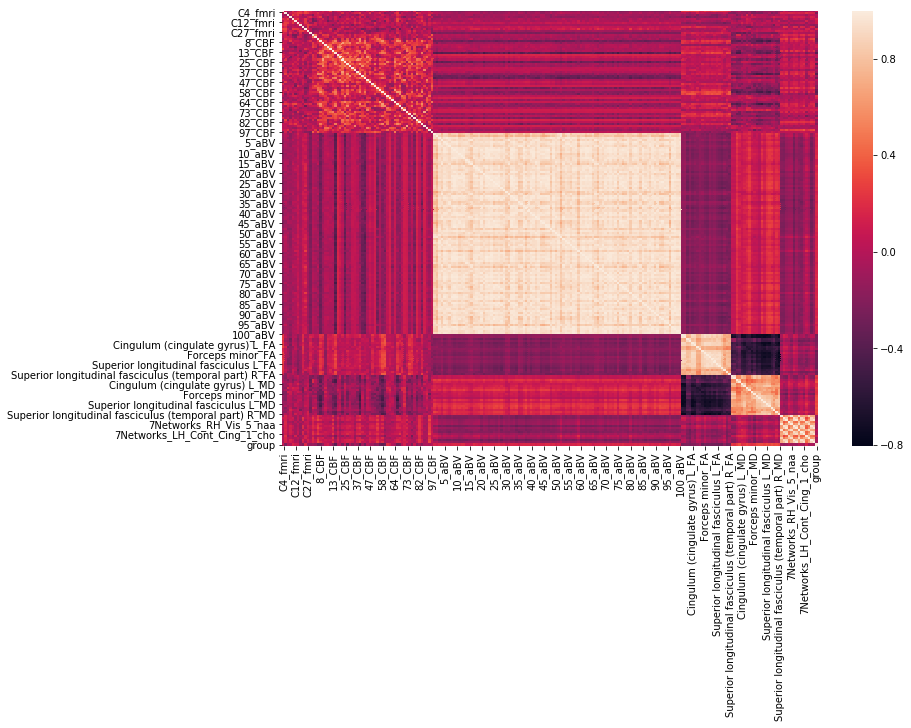

In [24]:
corr_matrix = data.corr()

plt.figure(figsize = (12,8))
sns.heatmap(corr_matrix)

plt.show()

Decomposing the modalities from the merged data frames.

In [25]:
fmri_reduced = data.loc[:, data.columns.str.contains('_fmri', regex=True)]
aBV_reduced = data.loc[:, data.columns.str.contains('_aBV', regex=True)]
FA_reduced = data.loc[:, data.columns.str.contains('_FA', regex=True)]
MD_reduced = data.loc[:, data.columns.str.contains('_MD', regex=True)]
CBF_reduced = data.loc[:, data.columns.str.contains('_CBF', regex=True)]
spectroscopy_reduced = data.loc[:, data.columns.str.contains('_glu|_cho|_ins|_naa', regex=True)]

Examining the explained variances of each modalities using Principal Component Analysis (PCA). 

In [26]:
n_pca_components = 5

print('Total explined variance with PCA of CBF features is {}'.format(PCA(n_components=n_pca_components).fit((CBF_reduced)).explained_variance_ratio_.sum()))
print('Total explined variance with PCA of aBV features is {}'.format(PCA(n_components=n_pca_components).fit((aBV_reduced)).explained_variance_ratio_.sum()))
print('Total explined variance with PCA of FA features is {}'.format(PCA(n_components=n_pca_components).fit((FA_reduced)).explained_variance_ratio_.sum()))
print('Total explined variance with PCA of MD features is {}'.format(PCA(n_components=n_pca_components).fit((MD_reduced)).explained_variance_ratio_.sum()))
print('Total explined variance with PCA of fmri features is {}'.format(PCA(n_components=n_pca_components).fit((fmri_reduced)).explained_variance_ratio_.sum()))
print('Total explined variance with PCA of spectroscopy features is {}'.format(PCA(n_components=n_pca_components).fit((spectroscopy_reduced)).explained_variance_ratio_.sum()))

Total explined variance with PCA of CBF features is 0.51690224549028
Total explined variance with PCA of aBV features is 0.9852896673002723
Total explined variance with PCA of FA features is 0.9248455008019215
Total explined variance with PCA of MD features is 0.9085453254499715
Total explined variance with PCA of fmri features is 0.6660702054209078
Total explined variance with PCA of spectroscopy features is 0.9907090249079245


Setting the number of features that will be selected as the most important in each cycle.

In [27]:
#Change number of selected features
number_of_selected_features = 1

Initializing Recursive Feature Elimination (RFE) objects with RandomForestClassifier and ExtraTreesClassifier.

In [28]:
#Feature Selection Algorithms
fs1 = RFE(RandomForestClassifier(n_estimators=100), n_features_to_select=number_of_selected_features)
fs2 = RFE(ExtraTreesClassifier(n_estimators=100, bootstrap=True), n_features_to_select=number_of_selected_features)

#Add more feature selection options

Defining the functions that will select each modality in pipelines. 

In [29]:
get_fmri = FunctionTransformer(lambda x: x[list(fmri_reduced.columns)], validate=False)
get_aBV = FunctionTransformer(lambda x: x[list(aBV_reduced.columns)], validate=False)
get_CBF = FunctionTransformer(lambda x: x[list(CBF_reduced.columns)], validate=False)
get_FA = FunctionTransformer(lambda x: x[list(FA_reduced.columns)], validate=False) 
get_MD = FunctionTransformer(lambda x: x[list(MD_reduced.columns)], validate=False)
get_spectroscopy = FunctionTransformer(lambda x: x[list(spectroscopy_reduced.columns)], validate=False)

Joining the preprocessing steps for each modality with FeatureUnion.

In [30]:
# Create a FeatureUnion with nested pipeline: process_and_join_features
join_features = FeatureUnion(
            transformer_list = [
                ('aBV_features', Pipeline([
                    ('selector', get_aBV),
                    ('pca', PCA(n_components=n_pca_components))
                ])),
                ('FA_features', Pipeline([
                    ('selector', get_FA),
                    ('pca', PCA(n_components=n_pca_components))
                ])),
                 ('MD_features', Pipeline([
                    ('selector', get_MD),
                    ('pca', PCA(n_components=n_pca_components))
                ])),
                ('spectroscopy_features', Pipeline([
                    ('selector', get_spectroscopy),
                    ('pca', PCA(n_components=n_pca_components))
                ])),
                ('fmri_features', Pipeline([
                    ('selector', get_fmri)
                ])),
                ('CBF_features', Pipeline([
                    ('selector', get_CBF)
                ]))
                
             ]
        )


Defining the pipelines for feature selection.

In [31]:
#Pipelines

pipe1 = Pipeline([('union', join_features),
                 ('fs', fs1)])

pipe2 = Pipeline([('union', join_features),
                 ('fs', fs2)])


#Add more pipelines



In [32]:
pipelist = [pipe1, pipe2] 

Calculating the time required for the features selection.

In [33]:
start = time.time()
for pipe in pipelist:
    pipe = pipe.fit((data.drop(labels=['group'], axis=1)), data['group'])

end = time.time()

In [34]:
num_of_loops = 100
Estimated_Time = ((end - start)*num_of_loops)
print('Estimated Time:',Estimated_Time/60,'min','or',Estimated_Time/3600,'h')

Estimated Time: 31.12678050994873 min or 0.5187796751658121 h


Performing feature selection num_of_loops times with different train-test splits in each loop.

In [35]:
start = time.time()
print('Program start to run at',time.localtime())
counter_collections=collections.Counter()


for pipe in pipelist:
    selectedfeatures=[]

    for i in range(num_of_loops):

        X_train, X_test, y_train, y_test = train_test_split(data.drop(labels=['group'], axis=1), data['group'], 
                                                           stratify=data['group'], test_size=0.2)


        # run pipelines
        pipe = pipe.fit(X_train, y_train)
        selectedfeatures.append(tuple(pipe.steps[1][1].get_support(indices=True)))          #for RF-RFE




    counter=collections.Counter(selectedfeatures)
    counter_collections = counter_collections + counter
    
    print('Most Common Selected Features:',np.array(counter.most_common))    #change according to number of selected features
    
    
    

print('Total Selected Features in all methods:',np.array(counter_collections.most_common))

end = time.time()
print('Computation Time:',(end - start)/60,'min')

Program start to run at time.struct_time(tm_year=2019, tm_mon=7, tm_mday=12, tm_hour=14, tm_min=28, tm_sec=12, tm_wday=4, tm_yday=193, tm_isdst=1)
Most Common Selected Features: <bound method Counter.most_common of Counter({(10,): 33, (0,): 14, (2,): 9, (21,): 9, (3,): 8, (60,): 7, (41,): 3, (29,): 2, (61,): 2, (71,): 2, (4,): 2, (11,): 1, (24,): 1, (65,): 1, (35,): 1, (40,): 1, (28,): 1, (6,): 1, (48,): 1, (34,): 1})>
Most Common Selected Features: <bound method Counter.most_common of Counter({(41,): 13, (61,): 12, (10,): 12, (24,): 12, (60,): 9, (34,): 8, (28,): 5, (21,): 5, (20,): 4, (51,): 2, (14,): 2, (22,): 2, (43,): 2, (6,): 2, (25,): 2, (9,): 1, (52,): 1, (29,): 1, (66,): 1, (3,): 1, (12,): 1, (42,): 1, (11,): 1})>
Total Selected Features in all methods: <bound method Counter.most_common of Counter({(10,): 45, (60,): 16, (41,): 16, (0,): 14, (21,): 14, (61,): 14, (24,): 13, (2,): 9, (3,): 9, (34,): 9, (28,): 6, (20,): 4, (29,): 3, (6,): 3, (11,): 2, (71,): 2, (4,): 2, (51,): 2,

In [36]:
selected_feature_index_list = [10, 60, 41]

### Defining names of the transformed features
pca_modality_list should follow the same order of modalities (that pca are applied) with transformer_list in join_feature object.

i.e.

 transformer_list = [
                ('aBV_features', Pipeline([
                    ('selector', get_aBV),
                    ('pca', PCA(n_components=n_pca_components))
                ])),
                ('FA_features', Pipeline([
                    ('selector', get_FA),
                    ('pca', PCA(n_components=n_pca_components))
                ])),
                 ('MD_features', Pipeline([
                    ('selector', get_MD),
                    ('pca', PCA(n_components=n_pca_components))
                ])),
                ('spectroscopy_features', Pipeline([
                    ('selector', get_spectroscopy),
                    ('pca', PCA(n_components=n_pca_components))
                ])),
                
and 

pca_modality_list = ['aBV', 'FA', 'MD', 'spectroscopy']

follows the same order in modality.


In [37]:
pca_col_list = []
pca_modality_list = ['aBV', 'FA', 'MD', 'spectroscopy']
for modality in pca_modality_list:
    for i in range(1, n_pca_components+1, 1):
        pca_col_list.append(modality + '_pca' + str(i))

###### Also add features that pca are not applied, in the same order with join feature object.

In [38]:
for i in fmri_reduced.columns:
    pca_col_list.append(i)
    
for i in CBF_reduced.columns:
    pca_col_list.append(i)

Inserting the indices of the transformed features that are mostly selected.  

In [39]:
print('Selected features: ', [pca_col_list[index] for index in selected_feature_index_list]) 

Selected features:  ['MD_pca1', '58_CBF', '20_CBF']


Defining the classifier for performing classification with selected features.

In [40]:
clf = RandomForestClassifier(n_estimators=100)

In [43]:
clf = ExtraTreesClassifier(n_estimators=100)

In [46]:
clf = SVC()

In [49]:
clf = LogisticRegression()

In [52]:
clf = KNeighborsClassifier()

Performing classification, calculating cross validation accuracy and confusion matrix.

In [53]:
select_features = FunctionTransformer(lambda x: x[:, selected_feature_index_list], validate=False)

pipe_clf = Pipeline([('union', join_features),
                     ('select_features', select_features),
                     ('clf', clf)])

predicted = cross_val_predict(pipe_clf, data.drop(labels=['group'], axis=1), data['group'], cv=10)

print('Accuracy:', accuracy_score(data['group'], predicted))

Accuracy: 0.3611111111111111


[Text(0,0.5,'HC'), Text(0,1.5,'PD-CN'), Text(0,2.5,'PD-MCI')]

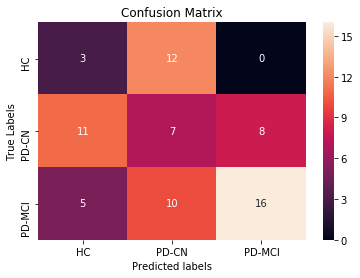

In [54]:
ax = plt.subplot()
sns.heatmap(confusion_matrix(data['group'], predicted), annot=True, ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['HC', 'PD-CN', 'PD-MCI'])
ax.yaxis.set_ticklabels(['HC', 'PD-CN', 'PD-MCI'])